In [10]:
import gym
import numpy as np
import operator
from IPython.display import clear_output
from time import sleep
import random
import itertools
import tqdm

tqdm.monitor_interval = 0


In [2]:
env = gym.make('Blackjack-v0')

In [3]:
env.reset()

(17, 10, False)

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [5]:
env.step(1)

((23, 10, False), -1.0, True, {})

In [6]:
env.reset()

(13, 3, False)

In [9]:
env.step(3)

(203, -1, False, {'prob': 1.0})

In [14]:
def create_random_policy(env):
    policy = {}
    for key in range(0, env.observation_space.n):
        current_end = 0
        p = {}
        for action in range(0, env.action_space.n):
            p[action] = 1 / env.action_space.n
        policy[key] = p
    return policy

def create_state_action_dictionary(env, policy):
    Q = {}
    for key in policy.keys():
         Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
    return Q

def run_game(env, policy, display=True):
    env.reset()
    episode = []
    finished = False

    while not finished:
        s = env.env.s
        if display:
            clear_output(True)
            env.render()
            sleep(1)

        timestep = []
        timestep.append(s)
        n = random.uniform(0, sum(policy[s].values()))
        top_range = 0
        for prob in policy[s].items():
            top_range += prob[1]
            if n < top_range:
                action = prob[0]
                break 
        state[0], reward, finished, info = env.step(action)
        timestep.append(action)
        timestep.append(reward)

        episode.append(timestep)

    if display:
        clear_output(True)
        env.render()
        sleep(1)
    return episode

def test_policy(policy, env):
    wins = 0
    r = 100
    for i in range(r):
        w = run_game(env, policy, display=False)[-1][-1]
        if w == 1:
            wins += 1
    return wins / r

def monte_carlo_e_soft(env, episodes=100, policy=None, epsilon=0.01):
    if not policy:
        policy = create_random_policy(env)  # Create an empty dictionary to store state action values    
    Q = create_state_action_dictionary(env, policy) # Empty dictionary for storing rewards for each state-action pair
    returns = {} # 3.
    
    for _ in range(episodes): # Looping through episodes
        G = 0 # Store cumulative reward in G (initialized at 0)
        episode = run_game(env=env, policy=policy, display=False) # Store state, action and value respectively 
        
        # for loop through reversed indices of episode array. 
        # The logic behind it being reversed is that the eventual reward would be at the end. 
        # So we have to go back from the last timestep to the first one propagating result from the future.
        
        for i in reversed(range(0, len(episode))):   
            s_t, a_t, r_t = episode[i] 
            state_action = (s_t, a_t)
            G += r_t # Increment total reward by reward on current timestep
            
            if not state_action in [(x[0], x[1]) for x in episode[0:i]]: # 
                if returns.get(state_action):
                    returns[state_action].append(G)
                else:
                    returns[state_action] = [G]   
                    
                Q[s_t][a_t] = sum(returns[state_action]) / len(returns[state_action]) # Average reward across episodes
                
                Q_list = list(map(lambda x: x[1], Q[s_t].items())) # Finding the action with maximum value
                indices = [i for i, x in enumerate(Q_list) if x == max(Q_list)]
                max_Q = random.choice(indices)
                
                A_star = max_Q # 14.
                
                for a in policy[s_t].items(): # Update action probability for s_t in policy
                    if a[0] == A_star:
                        policy[s_t][a[0]] = 1 - epsilon + (epsilon / abs(sum(policy[s_t].values())))
                    else:
                        policy[s_t][a[0]] = (epsilon / abs(sum(policy[s_t].values())))

    return policy

In [15]:
policy = monte_carlo_e_soft(env, episodes=500000)

AttributeError: 'Tuple' object has no attribute 'n'

In [7]:
def update_Q(Qsa, Qsa_next, reward, alpha, gamma):
    """ updates the action-value function estimate using the most recent time step """
    return Qsa + (alpha * (reward + (gamma * Qsa_next) - Qsa))

def epsilon_greedy_probs(env, Q_s, i_episode, eps=None):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    epsilon = 1.0 / i_episode
    if eps is not None:
        epsilon = eps
    policy_s = np.ones(env.nA) * epsilon / env.nA
    policy_s[np.argmax(Q_s)] = 1 - epsilon + (epsilon / env.nA)
    return policy_s

In [8]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        # initialize score
        score = 0
        # begin an episode, observe S
        state = env.reset()   
        # get epsilon-greedy action probabilities
        policy_s = epsilon_greedy_probs(env, Q[state], i_episode)
        # pick action A
        action = np.random.choice(np.arange(env.nA), p=policy_s)
        # limit number of time steps per episode
        for t_step in np.arange(300):
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            # add reward to score
            score += reward
            if not done:
                # get epsilon-greedy action probabilities
                policy_s = epsilon_greedy_probs(env, Q[next_state], i_episode)
                # pick next action A'
                next_action = np.random.choice(np.arange(env.nA), p=policy_s)
                # update TD estimate of Q
                Q[state][action] = update_Q(Q[state][action], Q[next_state][next_action], 
                                            reward, alpha, gamma)
                # S <- S'
                state = next_state
                # A <- A'
                action = next_action
            if done:
                # update TD estimate of Q
                #print(next_state)
                Q[state][action] = update_Q(Q[state][action], 0, reward, alpha, gamma)
                # append score
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

In [9]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

AttributeError: 'BlackjackEnv' object has no attribute 'nA'

In [14]:
# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(500)])

In [15]:
policy_sarsa

array([-1,  4,  4,  4,  3, -1,  2,  2,  3,  0, -1,  4,  1,  0,  1, -1,  5,
        0,  0,  0, -1,  3,  3,  3,  2, -1,  1,  3,  0,  0, -1,  2,  0,  3,
        1, -1,  3,  0,  0,  0, -1,  2,  2,  2,  0, -1,  3,  1,  3,  0, -1,
        0,  0,  2,  0, -1,  0,  2,  0,  0, -1,  3,  2,  1,  2, -1,  3,  2,
        1,  2, -1,  3,  3,  0,  1, -1,  0,  2,  0,  0, -1,  3,  2,  0,  4,
       -1,  4,  4,  0,  1, -1,  3,  2,  3,  1, -1,  3,  5,  3,  0, -1,  1,
        1,  1,  1, -1,  1,  2,  3,  3, -1,  2,  1,  0,  3, -1,  1,  0,  0,
        0, -1,  3,  3,  3,  3, -1,  1,  2,  2,  1, -1,  0,  2,  2,  1, -1,
        3,  0,  0,  0, -1,  1,  0,  1,  3, -1,  1,  3,  1,  2, -1,  0,  2,
        2,  1, -1,  0,  2,  0,  0, -1,  1,  0,  0,  2, -1,  5,  3,  0,  0,
       -1,  3,  1,  2,  2, -1,  0,  2,  0,  0, -1,  0,  0,  3,  3, -1,  1,
        1,  3,  3, -1,  0,  3,  0,  3, -1,  3,  1,  3,  3, -1,  1,  1,  2,
        0, -1,  3,  1,  0,  2, -1,  1,  1,  0,  1, -1,  1,  2,  0,  2, -1,
        3,  1,  1,  2, -1

In [19]:
Q_sarsa[268]

array([-4.31020292, -4.30972435, -4.31479837, -4.3151394 , -4.37754542,
       -4.47654306])

In [20]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # initialize score
        score = 0
        # begin an episode, observe S
        state = env.reset()
        while True:
            # get epsilon-greedy action probabilities
            policy_s = epsilon_greedy_probs(env, Q[state], i_episode)
            # pick next action A
            action = np.random.choice(np.arange(env.nA), p=policy_s)
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            # add reward to score
            score += reward
            # update Q
            Q[state][action] = update_Q(Q[state][action], np.max(Q[next_state]), \
                                                  reward, alpha, gamma)        
            # S <- S'
            state = next_state
            # until S is terminal
            if done:
                # append score
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

Episode 5000/5000

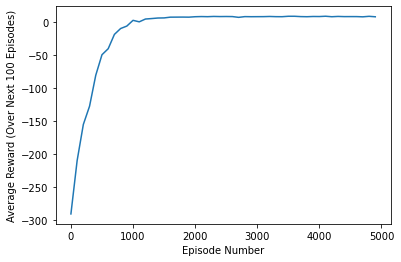

Best Average Reward over 100 Episodes:  8.38


In [22]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .1)

In [23]:
# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(500)])
policy_sarsamax

array([ 0,  4,  4,  4,  0, -1,  0,  2,  0,  0, -1,  0,  2,  0,  0, -1,  5,
        0,  0,  0, -1,  3,  3,  3,  0, -1,  0,  0,  3,  3, -1,  0,  0,  0,
        0, -1,  3,  0,  2,  0, -1,  0,  0,  0,  2, -1,  2,  2,  0,  0, -1,
        0,  2,  2,  0, -1,  0,  2,  2,  1, -1,  0,  0,  0,  2, -1,  2,  2,
        0,  0, -1,  3,  0,  0,  0, -1,  0,  2,  0,  0, -1,  3,  0,  0,  4,
        0,  4,  4,  3,  3, -1,  3,  3,  3,  3, -1,  0,  5,  0,  0, -1,  1,
        1,  1,  2, -1,  2,  2,  0,  0, -1,  0,  0,  2,  0, -1,  1,  2,  0,
        0, -1,  3,  3,  3,  0, -1,  0,  0,  0,  0, -1,  3,  0,  0,  0, -1,
        3,  0,  1,  0, -1,  0,  0,  0,  2, -1,  2,  2,  0,  0, -1,  0,  2,
        0,  0, -1,  0,  2,  0,  0, -1,  0,  0,  0,  2, -1,  2,  2,  0,  3,
       -1,  3,  0,  0,  0, -1,  0,  1,  0,  0, -1,  3,  0,  0,  1, -1,  1,
        1,  0,  3, -1,  0,  3,  3,  3, -1,  3,  1,  3,  3, -1,  1,  1,  1,
        2, -1,  2,  2,  0,  0, -1,  0,  2,  2,  2, -1,  1,  2,  0,  2, -1,
        1,  1,  1,  2, -1

In [24]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # initialize score
        score = 0
        # begin an episode
        state = env.reset()
        # get epsilon-greedy action probabilities
        policy_s = epsilon_greedy_probs(env, Q[state], i_episode, 0.005)
        while True:
            # pick next action
            action = np.random.choice(np.arange(env.nA), p=policy_s)
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            # add reward to score
            score += reward
            # get epsilon-greedy action probabilities (for S')
            policy_s = epsilon_greedy_probs(env, Q[next_state], i_episode, 0.005)
            # update Q
            Q[state][action] = update_Q(Q[state][action], np.dot(Q[next_state], policy_s), \
                                                  reward, alpha, gamma)        
            # S <- S'
            state = next_state
            # until S is terminal
            if done:
                # append score
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

Episode 10000/10000

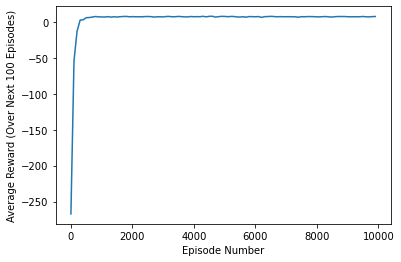

Best Average Reward over 100 Episodes:  8.24


In [25]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

In [26]:
# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(500)])
policy_expsarsa

array([ 0,  4,  4,  4,  0, -1,  0,  2,  0,  2, -1,  0,  2,  0,  0, -1,  5,
        0,  0,  2, -1,  3,  3,  3,  0, -1,  0,  0,  3,  0, -1,  0,  0,  0,
        0, -1,  3,  3,  2,  0, -1,  0,  0,  0,  2, -1,  2,  2,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  2,  0,  3, -1,  0,  0,  0,  2, -1,  2,  2,
        3,  0, -1,  3,  3,  0,  0, -1,  3,  2,  0,  3, -1,  0,  0,  0,  4,
        0,  4,  4,  3,  3, -1,  3,  3,  0,  0, -1,  3,  5,  0,  0, -1,  1,
        1,  1,  2, -1,  0,  2,  0,  0, -1,  0,  2,  0,  2, -1,  1,  0,  0,
        2, -1,  1,  3,  3,  0, -1,  0,  0,  0,  0, -1,  3,  0,  0,  0, -1,
        3,  0,  0,  0, -1,  0,  0,  0,  2, -1,  2,  1,  0,  0, -1,  0,  0,
        0,  0, -1,  0,  2,  0,  2, -1,  0,  3,  0,  2, -1,  2,  1,  3,  3,
       -1,  3,  0,  0,  0, -1,  0,  1,  0,  0, -1,  3,  3,  3,  1, -1,  1,
        1,  0,  1, -1,  3,  3,  0,  0, -1,  3,  1,  0,  0, -1,  1,  1,  1,
        2, -1,  2,  2,  0,  0, -1,  0,  2,  2,  2, -1,  1,  2,  0,  2, -1,
        1,  1,  1,  2, -1

In [27]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy 
        overwrite the current returned on the state
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        # Constant-alpha
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [28]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode ##### Incremental Mean ###
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [49]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.3)

Episode 500000/500000.

In [55]:
policy

array([-1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1

In [50]:
# print the estimated optimal policy
policy = np.array([np.argmax(policy[key]) if key in policy else -1 for key in np.arange(500)])
policy

array([-1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1

In [32]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [34]:
env.reset()

242

In [38]:
action, reward, done, _ = env.step(action)

(202, -1, False, {'prob': 1.0})

In [42]:
from time import sleep

### APPLY Expected SARSA POLICY

In [44]:
#
action = env.reset()
done = False
final_reward=0
while done==False:
    action=policy_expsarsa[action]
    action, reward, done, _ = env.step(action)
    final_reward = final_reward + reward
    env.render()
    sleep(1)
print(final_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
11


### APPLY Q-LEARNING POLICY

In [45]:
# policy_sarsamax 
action = env.reset()
done = False
final_reward=0
while done==False:
    action=policy_sarsamax[action]
    action, reward, done, _ = env.step(action)
    final_reward = final_reward + reward
    env.render()
    sleep(1)
print(final_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y|

### APPLY SARSA POLICY

In [48]:
# policy_sarsa
action = env.reset()
done = False
final_reward=0
while done==False:
    action=policy_sarsa[action]
    action, reward, done, _ = env.step(action)
    final_reward = final_reward + reward
    env.render()
    sleep(1)
print(final_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
11


In [ ]:
# policy_sarsa
# action = env.reset()
# done = False
# final_reward=0
# while done==False:
#     action=policy[action]
#     action, reward, done, _ = env.step(action)
#     final_reward = final_reward + reward
#     env.render()
#     sleep(1)
# print(final_reward)